In [1]:
from data_v2 import *
import numpy as np
import fnmatch
from mvar import *
from decimal import Decimal


In [2]:
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']#, 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
#         'WIKI/JPM', 'WIKI/', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

models = {'ffnn_deterministic', 'ffnn_bayesian', 'lstm_deterministic', 'lstm_bayesian', 'gru_deterministic', 'gru_bayesian', 'tanh_deterministic', 'tanh_bayesian', 'relu_deterministic', 'relu_bayesian' , 'var_deterministic', 'var_bayesian'}
models_justf = {'ffnn', 'lstm', 'gru', 'tanh', 'relu', 'var'} #{'var'} 
time_period = 'weekly' #{'daily', 'weekly', 'monthly', 'quarterly'}

n_steps = [7, 15, 30, 60]
#stocks = ['WIKI/BAC']
gamma = 1
n_stocks = len(stocks)
batch_size = 100
#gamma = [0, 1, 20, 500]
bayes_iterations = 100

n_epochs = 3000



In [3]:
df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

TypeError: unsupported operand type(s) for +: 'int' and 'set'

In [3]:
def test_dim(n_steps):
    n_steps = int(n_steps)
    df =np.array(get_data(stocks= stocks, col = 'weekly'))
    X,y = split_sequence(df, n_steps)
    X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)
    return y_test.shape[0]

In [4]:
def just_data(stocks,col, n_steps):
    df =np.array(get_data(stocks= stocks, col = "weekly"))
    X,y = split_sequence(df, n_steps)
    X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)
    return X_test

In [12]:

n_stocks = len(stocks)

for step in n_steps:
    var_hist = []
    X_test = just_data(stocks, 'weekly' ,step)
    for tstamp in range(X_test.shape[0]):
        var_hist.append(np.asmatrix(np.cov(X_test[tstamp, :, :], rowvar = False)))

        for mod in models_justf:
            path = './results/n_steps/' + 'weekly' + '_' + str(step) + '_'
            np.savez(str(path + '_' + '_' + mod + '_deterministic_' + 'var'), var_hist)

###### MSE

In [13]:
from collections import defaultdict
import os

groups = defaultdict(list)

for filename in os.listdir('./results/n_steps/'):
    if fnmatch.fnmatch(filename, '*mse*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[days, model, estimation, eval_].append(filename)
        
mse_to_avg = []
for key, fnames in groups.items():
    mse_load = []
    for f in range(len(fnames)):
        val = np.load(str('./results/n_steps/' + fnames[f]))
        mse_load.append(val.f.arr_0)
    mse_to_avg.append((key[0:3], round(np.mean(mse_load),5)))

## Mean, Sigma

In [16]:
from collections import defaultdict
import tqdm


groups = defaultdict(list)

for filename in os.listdir('./results/n_steps/'):
    if fnmatch.fnmatch(filename, '*mu*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[days, model, estimation, eval_].append(filename)
        
y_hat = []
for key, fnames in tqdm.tqdm(groups.items()):
    mu_per_group = np.empty((test_dim(key[0]), n_stocks))
    kk = 0
    for f in range(len(fnames)):
        val = np.load(str('./results/n_steps/' + fnames[f]))
        mu_per_group[:,kk] = val.f.arr_0
        kk += 1
    y_hat.append(mu_per_group)
     

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [05:33<00:00,  5.14s/it]


In [17]:
from collections import defaultdict

groups = defaultdict(list)

for filename in os.listdir('./results/n_steps/'):
    if fnmatch.fnmatch(filename, '*var.npz'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[days, model, estimation, eval_].append(filename)
        
sigma_hat = []
for key, fnames in tqdm.tqdm(groups.items()):
    if key[2] == 'deterministic':
        var_hist = np.load(str('./results/n_steps/' + 'weekly_' + key[0] + '___ffnn_deterministic_var.npz'))
        var_hist = var_hist.f.arr_0
        sigma_hat.append(var_hist)
    
    elif key[2] == 'bayesian':
        var_hist = np.load(str('./results/n_steps/' + 'weekly_' + key[0] + '___ffnn_deterministic_var.npz'))
        var_hist = var_hist.f.arr_0
        dim_test = test_dim(key[0])
        sigma_per_group = np.empty((dim_test, n_stocks))
        kk = 0
        covar_bayes = np.empty((dim_test, n_stocks, n_stocks))
        for fa in range(len(fnames)):
            val = np.load(str('./results/n_steps/' + fnames[fa]))
            sigma_per_group[:,kk] = val.f.arr_0
            kk += 1
        for m in range(dim_test):
            covar_bayes[m,:,:] = np.diag(sigma_per_group[m])
            np.fill_diagonal(var_hist[m], np.diag(covar_bayes[m]))
        
        sigma_hat.append(var_hist)
     

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [02:13<00:00,  2.78s/it]


## It's important to make sure mu and sigma are consistent. Hence we look for to order indices in sigma_hat in the same way as in y_hat.

In [18]:
groups = defaultdict(list)

for filename in os.listdir('./results/n_steps/'):
    if fnmatch.fnmatch(filename, '*mu*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[days, model, estimation, eval_].append(filename)
        

mu_names = []
for key in groups.keys():
    mu_names.append(key[:3])

In [19]:
groups = defaultdict(list)

for filename in os.listdir('./results/n_steps/'):
    if fnmatch.fnmatch(filename, '*var.npz'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[days, model, estimation, eval_].append(filename)


var_names = []
for key in groups.keys():
    var_names.append(key[:3])

In [20]:
idxs = []
for l in range(len(mu_names)):
    indices = [i for i, x in enumerate(var_names) if x == mu_names[l]]
    idxs.append(indices[0])

## Now that we have mus and sigmas we should run a loop and calculate portfolio weights

#### First step is to subset the the y_hat and sigma_hat in 4 sets representing the time period of calculation. Then we will get 4 sets, one for each panel in the graph.

### 7

In [21]:
ind_1 = [i for i, x in enumerate(np.matrix(mu_names)[:,0]) if x == '7']
mu_1 = []
idxs_pick_1 = []

for ne in ind_1:
    mu_1.append(y_hat[ne])
    idxs_pick_1.append(idxs[ne])
    
    
    
sigma_1 = []
for ne in idxs_pick_1:
    sigma_1.append(sigma_hat[ne])
    

In [14]:
def log_likelihood(mean, sigma, data):
        sigma = np.sqrt(np.diagonal(sigma, axis1 = 1, axis2 = 2))
        s = (data - mean) ** 2 / (2 * (sigma ** 2))
        pdfs = np.exp(- s)
        pdfs /= np.sqrt(2 * np.pi) * sigma
        return np.nansum(np.log(pdfs))/len(data)

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'weekly'

df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps = 7)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_7 = []
for ne in range(len(mu_1)):
    log_lik_7.append(log_likelihood(mu_1[ne].squeeze(), sigma_1[ne].squeeze(), y_test.squeeze()))

In [15]:
log_lik_7

[-16.716321191946882,
 7.11196832796189,
 7.616602779931505,
 6.660839277588221,
 6.285894035008501,
 6.844890757085965,
 7.444395513045977,
 4.007819779320839,
 7.709706884534877,
 7.456525489339937,
 2.5960003445217854,
 7.60531627828509]

## 15

In [22]:
ind_2 = [i for i, x in enumerate(np.matrix(mu_names)[:,0]) if x == '15']
mu_2 = []
idxs_pick_2 = []

for ne in ind_2:
    mu_2.append(y_hat[ne])
    idxs_pick_2.append(idxs[ne])
    
    
    
sigma_2 = []
for ne in idxs_pick_2:
    sigma_2.append(sigma_hat[ne])
    

In [17]:
df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_15= []
for ne in range(len(mu_2)):
    log_lik_15.append(log_likelihood(mu_2[ne].squeeze(), sigma_2[ne].squeeze(), y_test.squeeze()))
    
log_lik_15

[-16.46128336054818,
 7.234484230926234,
 7.542005897724494,
 6.592721283389645,
 6.574195550343203,
 7.0610082739578965,
 7.549002317327377,
 6.41838357004676,
 7.803862223140094,
 6.572668567823522,
 2.232001253172516,
 7.87504640528649]

### 30

In [23]:
ind_3 = [i for i, x in enumerate(np.matrix(mu_names)[:,0]) if x == '30']
mu_3 = []
idxs_pick_3 = []

for ne in ind_3:
    mu_3.append(y_hat[ne])
    idxs_pick_3.append(idxs[ne])
    
    
    
sigma_3 = []
for ne in idxs_pick_3:
    sigma_3.append(sigma_hat[ne])
    

In [19]:
df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps = 30)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_30= []
for ne in range(len(mu_3)):
    log_lik_30.append(log_likelihood(mu_3[ne].squeeze(), sigma_3[ne].squeeze(), y_test.squeeze()))
    
log_lik_30

[-16.18295888378138,
 7.611916167637429,
 7.8853925231656,
 7.146899897601773,
 6.39573969922551,
 6.437868525195207,
 8.04156512199557,
 6.963375017816108,
 7.604160271269116,
 5.379405226213685,
 2.9719430790228976,
 8.104631647079533]

### 60

In [24]:
ind_4 = [i for i, x in enumerate(np.matrix(mu_names)[:,0]) if x == '60']
mu_4 = []
idxs_pick_4 = []

for ne in ind_4:
    mu_4.append(y_hat[ne])
    idxs_pick_4.append(idxs[ne])
    
    
    
sigma_4 = []
for ne in idxs_pick_4:
    sigma_4.append(sigma_hat[ne])
    


In [21]:
df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps = 60)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_60= []
for ne in range(len(mu_4)):
    log_lik_60.append(log_likelihood(mu_4[ne].squeeze(), sigma_4[ne].squeeze(), y_test.squeeze()))
    
log_lik_60

[-16.109753945152804,
 7.423974233789181,
 7.779716064013242,
 7.804433856902351,
 6.6758618179250915,
 5.500230400952052,
 -9.304594944279554,
 7.858492678375849,
 -7.756869584208844,
 5.707704270589113,
 3.771813434526614,
 7.824187372107812]

In [44]:
for l in range(len(log_lik_15)):
    print(np.round(log_lik_60[l], 3))

-16.11
7.424
7.78
7.804
6.676
5.5
-9.305
7.858
-7.757
5.708
3.772
7.824


#### At last! Portfolio Optimization!

In [25]:
from mvar import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'weekly'

df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps = 7)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_1[0].shape[0]).index)

w0 = [1/mu_1[0].shape[1]] * mu_1[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_1 = []
exprets_1 = []
pfvar_1 = []

for i_1 in range(len(mu_1)): 
    historical_weights = []    
    for ts in range(len(mu_1[i_1])):
        hv = mv_portfolio(returns = np.asmatrix(mu_1[i_1][ts]).T, variance = sigma_1[i_1][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma)
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)
    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_1.append(portfolio_value)
    
portfolio_1 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_1)).T)
portfolio_1 = pd.DataFrame(portfolio_1).set_index(dates)



In [26]:
from benchmark_2 import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']

port_hist = historical_portfolio_fun(stocks, 7, batch_size, 'weekly', gamma)
portfolio_1 = portfolio_1.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, 7, batch_size, col = 'weekly')
portfolio_1 = portfolio_1.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [27]:
from mvar import *

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'weekly'

df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = "weekly")
dates = np.asarray(df.tail(mu_2[0].shape[0]).index)
w0 = [1/mu_2[0].shape[1]] * mu_2[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_2 = []
exprets_2 = []
pfvar_2 = []

for i_2 in range(len(mu_2)): 
    historical_weights = []    
    for ts in range(len(mu_2[i_2])):
        historical_weights.append(mv_portfolio(returns = np.asmatrix(mu_2[i_2][ts]).T, variance = sigma_2[i_2][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma))
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_2.append(portfolio_value)
    
portfolio_2 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_2)).T)
portfolio_2 = pd.DataFrame(portfolio_2).set_index(dates)


In [28]:
port_hist = historical_portfolio_fun(stocks, 15, batch_size, 'weekly', gamma)
portfolio_2 = portfolio_2.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, 15, batch_size, col = 'weekly')
portfolio_2 = portfolio_2.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [29]:
from mvar import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'weekly'

df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps = 30)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = "weekly")
dates = np.asarray(df.tail(mu_3[0].shape[0]).index)
w0 = [1/mu_3[0].shape[1]] * mu_3[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_3 = []
exprets_3 = []
pfvar_3 = []

for i_3 in range(len(mu_3)): 
    historical_weights = []    
    for ts in range(len(mu_3[i_3])):
        hv = mv_portfolio(returns = np.asmatrix(mu_3[i_3][ts]).T, variance = sigma_3[i_3][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma)
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_3.append(portfolio_value)
    
portfolio_3 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_3)).T)
portfolio_3 = pd.DataFrame(portfolio_3).set_index(dates)



In [30]:
port_hist = historical_portfolio_fun(stocks, 30, batch_size, 'weekly', gamma)
portfolio_3 = portfolio_3.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, 30, batch_size, col = 'weekly')
portfolio_3 = portfolio_3.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [31]:
from mvar import *

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'weekly'

df =np.array(get_data(stocks= stocks, col = "weekly"))
X,y = split_sequence(df, n_steps = 30)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = "weekly")
dates = np.asarray(df.tail(mu_4[0].shape[0]).index)
w0 = [1/mu_4[0].shape[1]] * mu_4[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_4 = []
exprets_4 = []
pfvar_4 = []

for i_4 in range(len(mu_4)): 
    historical_weights = []    
    for ts in range(len(mu_4[i_4])):
        historical_weights.append(mv_portfolio(returns = np.asmatrix(mu_4[i_4][ts]).T, variance = sigma_4[i_4][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma))
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_4.append(portfolio_value)
    
portfolio_4 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_4)).T)
portfolio_4 = pd.DataFrame(portfolio_4).set_index(dates)




In [32]:
port_hist = historical_portfolio_fun(stocks, 60, batch_size, 'weekly', gamma)
portfolio_4 = portfolio_4.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, 60, batch_size, col = 'weekly')
portfolio_4 = portfolio_4.assign(equal=pd.Series(port_equal.squeeze()).values)

4


### Time for some graph magic

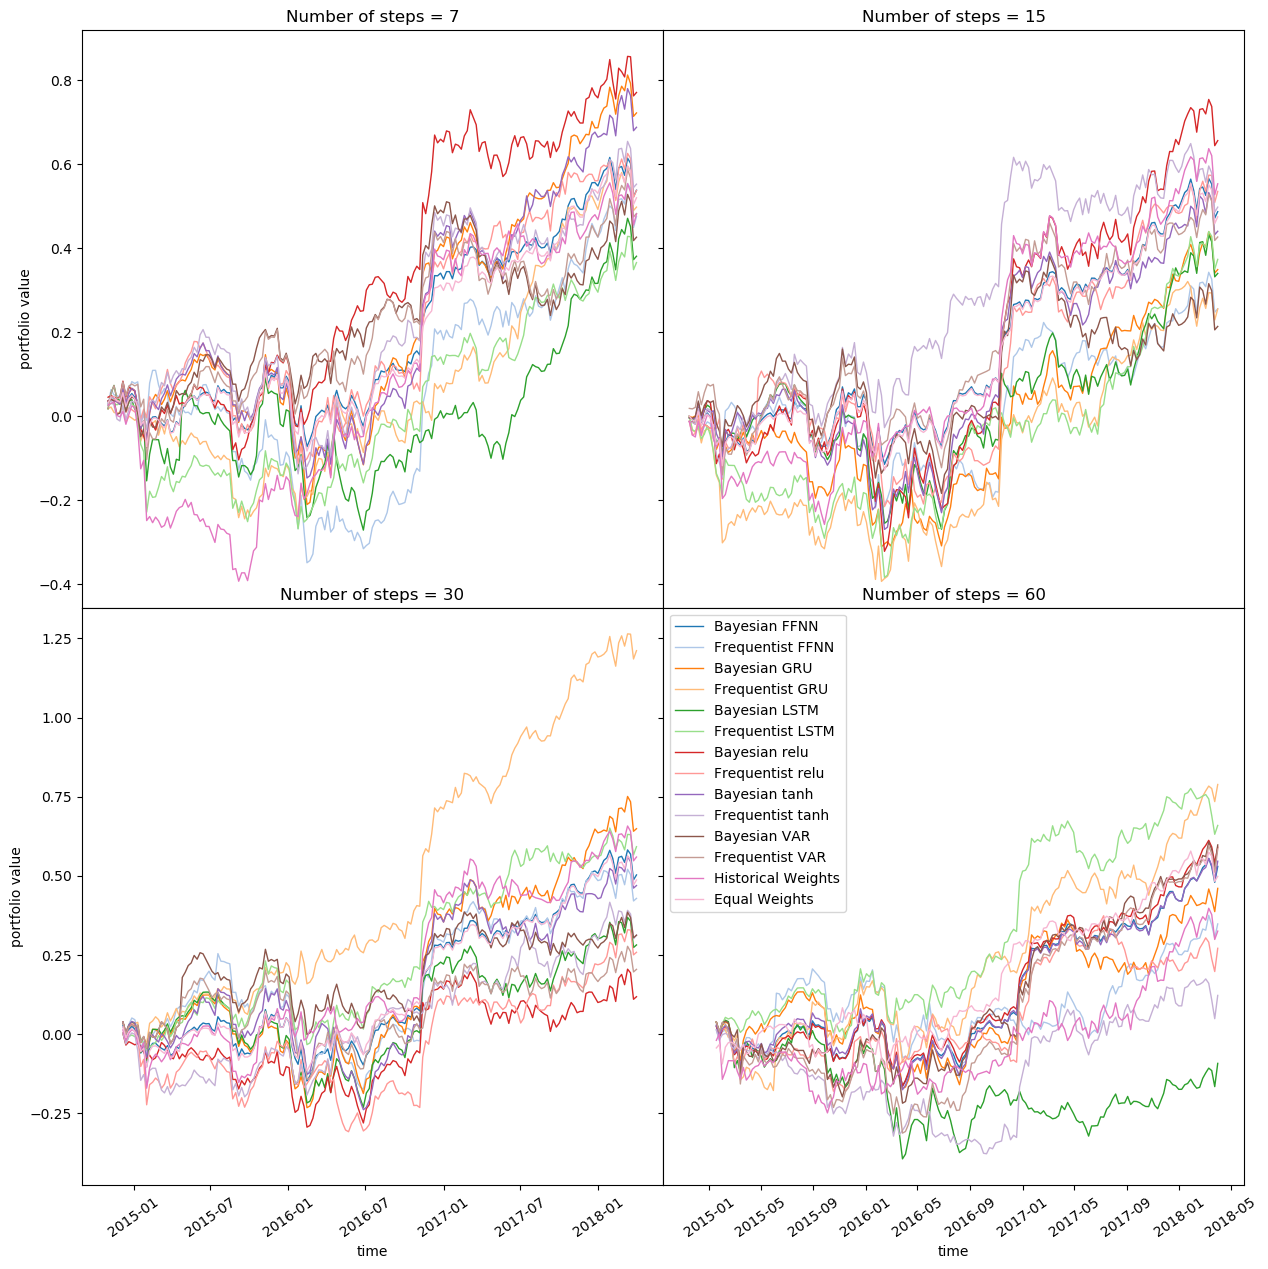

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = 20

cm = plt.get_cmap('tab20')





plt.style.use('default')
plt.rc('lines', linewidth= 1.0)
#plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(2, 2, figsize=(15,15), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, linewidth= 100)

#xfmt = mdates.DateFormatter('%Y-%m-%d')

(ax1, ax2), (ax3, ax4) = axs
#fig.suptitle('Sharing x per column, y per row')
ax1.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
p1 = ax1.plot(portfolio_1)
ax1.set_title('Number of steps = 7')
#ax1.set_xticklabels([df.index[:100]])
ax2.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.plot(portfolio_2)
ax2.set_title('Number of steps = 15')
ax3.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax3.plot(portfolio_3)
ax3.set_title('Number of steps = 30')
ax4.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

ax4.plot(portfolio_4)
ax4.set_title('Number of steps = 60')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='portfolio value')
    ax.label_outer()
    ax.xaxis.set_tick_params(rotation=35)
    


ax.legend((p1), ('Bayesian FFNN', 'Frequentist FFNN', 'Bayesian GRU', 'Frequentist GRU',
                'Bayesian LSTM', 'Frequentist LSTM', 'Bayesian relu', 'Frequentist relu',
                'Bayesian tanh', 'Frequentist tanh', 'Bayesian VAR', 'Frequentist VAR',
                'Historical Weights', 'Equal Weights'), loc='best', shadow=False)